# 인물사진 모드 만들기

__학습목표__: 딥러닝을 적용하여 핸드폰 인물 사진 모드를 따라해보자.

1. 배경이 있는 셀카를 준비한다.
2. Semantic segmentation으로 피사체와 배경을 분리한다.
3. Blurring 기술로 배경을 흐리게 한다.
4. 피사체를 원래 위치에 합성한다.

## 1. 이미지 준비

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

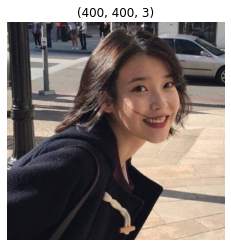

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/iu.jpg'
img_orig = cv2.imread(img_path)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title(img_orig.shape)
plt.axis('off')
plt.show()

## 2. Semantic Segmentation

1. DeepLabModel 구조를 가지고 pretrained weight 를 학습시킨다
2. 준비된 이미지를 네트워크에 입력
3. `person` 라벨로 구분된 객체를 검출한다.

> __Image Segmentation__<br>
여러 세부 태스크에 따라 다양한 기준으로 객체를 추출하는 것.
모든 픽셀에 라벨을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정한다.

> __Semantic segmentation__<br>
물리적 의미 단위로 인식하는 세그멘테이션.
![semantic segmentation](https://divamgupta.com/assets/images/posts/imgseg/teaser.png)

> __Instance segmentation__<br>
시맨틱 세그맨테이션은 사람이면 누구든지 같은 라벨로 표현된다.
인스턴스 세그멘테이션은 더 나아가 개인별로 다른 라벨을 가지게 한다.

### 시멘틱 세그맨테이션 적용

구글에서 제공하는 [DeepLab](https://github.com/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb) 모델 구조를 그대로 사용해 `DeepLabModel` 클래스를 만든다

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
    
    # 세그맨테이션을 수행하는 함수
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

구글이 제공하는 deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight을 다운로드하고 DeepLabModel 을 초기화합니다. 이 모델은 PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3 버전입니다.

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


준비해준 이미지를 네트워크에 입력한다.

In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max()) 
#  HWC(Height, Width, Channel) 

(400, 400, 3) (513, 513, 3) 15


 DeepLab은 PASCAL VOC의 라벨로 학습되었습니다. 제공하는 라벨 종류는 아래와 같습니다.

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

seg_map.max() : 세그맨테이션 맵에서 가장 큰 값인 15는 'person'를 의미한다.
`person` 라벨을 가진 영역만 검출해 내고 싶다. 마스크를 만들고 시각화 해본다.

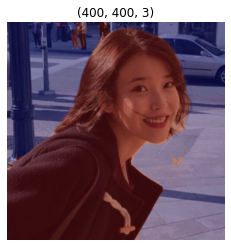

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization, 원본이미지에 그림형태로 출력하기 위해
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET) # 색 적용
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.title(img_orig.shape)
plt.axis('off')
plt.show()

### 세그맨테이션 결과를 원래 크기로 복원

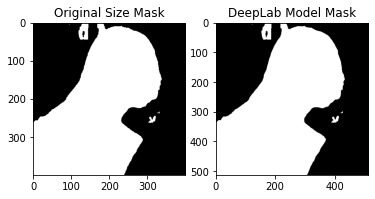

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) 
# 보간법(interpolation)은 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

## 3. Blurring

1. `blur()`함수를 이용하여 배경을 흐리게 만든다.
2. 흐려진 이미지에서 세그맨테이션 마스크를 이용해 배경만 추출한다.

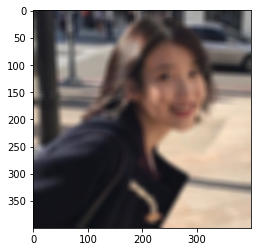

In [9]:
# 사진 흐리게
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

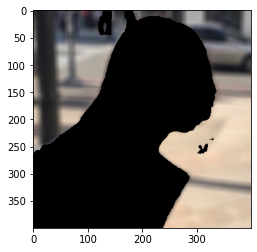

In [10]:
# 배경 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) # 이미지 반전 (배경:255, 사람:0)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 4. 이미지 합성

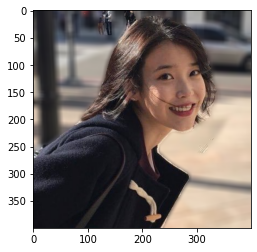

In [11]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
print(img_mask_color.shape)
print(img_orig.shape)
print(img_bg_blur.shape)

(400, 400, 3)
(400, 400, 3)
(400, 400, 3)


원본과 비교해보기

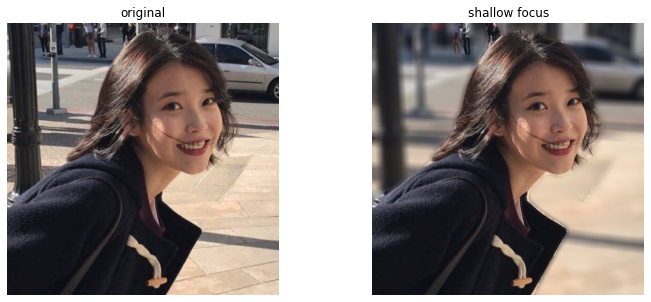

In [13]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title('original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('shallow focus')
plt.axis('off')

plt.show()